In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing
#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools, file_management
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk

In [2]:
############# gather data from all experiments ###############
folders = ['Galvanotaxis_Confocal_40x_37C_10s_smooth',
          'CK666_Confocal_40x_37C_smooth',
          'ParaNitroBlebbistatin_Confocal_40x_37C_smooth']
smlst = []
atilst = []
for f in folders:
    tempfl = f'E:/Aaron/{f}/'
    sm = pd.read_csv(tempfl + 'Data_and_Figs/Shape_Metrics.csv', index_col = 0)
    
    excludes = pd.read_csv(tempfl + 'Data_and_Figs/ListToExclude.csv', index_col=0)
    exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
    sm = sm.loc[[x for x in sm.index if x not in exlist]]

    #add all of the other metrics from the single csv files
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes=60)
        csvlist = [tempfl + 'processed_data/' + i +'_cell_info.csv' for i in sm.index.to_list()]
        celllist = pool.map(file_management.multicsv, csvlist)
        pool.close()
        pool.join()
    cellinfo = pd.concat(celllist)

    smlst.append(sm)
    atilst.append(cellinfo)
    
### make dataframes and merge    
smdf = pd.concat(smlst)
atidf = pd.concat(atilst)
df = smdf.merge(atidf.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')

df['CellID'] = [x.split('_frame')[0] for x in df.cell.to_list()]

In [3]:
########### FILTER THE DATA A BIT ###############
print(len(df))

############# filter out shape outliers #############
df = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)]
df = df[(df.Cell_SurfaceArea < 1800) & (df.Cell_SurfaceArea > 500)]
print(len(df))

############## filter out speed outliers #############
df = df.drop(df[df.isin(df[df.speed>0.8].CellID.unique()).any(axis=1)].index).reset_index(drop=True)
print(len(df))

############# filter out galvanotaxis ##############
df = df.drop(df[(df.CellID.isin([x for x in df.CellID.unique() if '3mA' in x])) & (df.frame>180)].index).reset_index(drop=True)
print(len(df))

141833
135567
126822
113378


In [4]:
######### Perform PCA and divide cells into shape space bins ################


savedir = 'E:/Aaron/Combined_37C_Confocal_PCA_smooth/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10


#get coeffs only
coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]


# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1

df_trans = df_trans.drop(columns = 'Cell_Volume')



################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})

    
mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine metrics and digitized pcs
df_dig = df.merge(df_dig, left_index = True, right_index = True)
#save the digitized PCs for the shape space
df_dig.to_csv(savedir+"Shape_Metrics_with_Digitized_PCs.csv")
#save just the PCs with the other cell data, no digitized PCs
digless = df_dig.drop(columns=[x for x in df_dig.columns.to_list() if 'shcoeff' in x or 'bin' in x or '.1' in x]).reset_index(drop=True)
digless.to_csv(savedir+"Shape_Metrics_with_PCs.csv")

########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

                
                
################## save PC meshes ##################
pcmeshdir = savedir + 'PC_Meshes/'
if not os.path.exists(pcmeshdir):
    os.makedirs(pcmeshdir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(pcmeshdir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()

####### also save the pca object for later use ###########
pk.dump(pca, open(savedir+"pca.pkl","wb"))



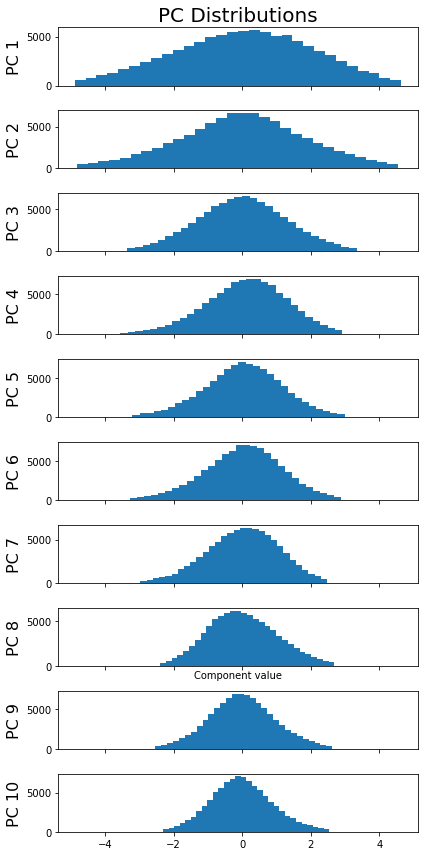

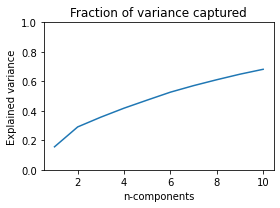

In [5]:
##################### PCA relevant figures #######################


########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(digless[pc_names].iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(savedir+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(savedir + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = savedir + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )

In [6]:
############# CALCULATE A BUNCH OF METRICS ###################
from scipy.spatial import ConvexHull
#get directories and open separated datasets
from itertools import groupby
from operator import itemgetter
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A


savedir = 'E:/Aaron/Combined_37C_Confocal_PCA_smooth/'
    
    
nbins = 11


#get directories
TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_with_PCs.csv', index_col = 0)

#remove the "Cell_" from PCs
for x in TotalFrame.columns.to_list():
    if 'PC' in x:
        TotalFrame = TotalFrame.rename(columns = {x:x.replace('Cell_','')})
#add a column that identifies cells across all frames
TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.cell.to_list()]

#Add Elongation metric
TotalFrame['Cell_Elongation'] = TotalFrame['Cell_MajorAxis']/TotalFrame['Cell_MinorAxis']

#Add Volume Ratios
TotalFrame['Volume_Front_Ratio'] = TotalFrame.Cell_Volume_Front/TotalFrame.Cell_Volume
TotalFrame['Volume_Right_Ratio'] = TotalFrame.Cell_Volume_Right/TotalFrame.Cell_Volume
TotalFrame['Volume_Top_Ratio'] = TotalFrame.Cell_Volume_Top/TotalFrame.Cell_Volume


#sphericity calculation (ratio of surface area of circle with same volume to actual surface area)
Cell_Sphere = []
for index, row in TotalFrame.iterrows():
    #cell sphericity
    r = ((3*row.Cell_Volume)/(4*math.pi)) ** (1/3)
    SA = 4*math.pi*r
    Cell_Sphere.append(SA/row.Cell_SurfaceArea)
TotalFrame['Cell_Sphericity'] = Cell_Sphere


######### Get angles of long axes relative to the axis of trajectory #############
RelativeAngles = pd.DataFrame()
vectors = sorted([i for i in row.index if 'MajorAxis_Vec' in i])
# row = RandomRotations.iloc[0]
for index, row in TotalFrame.iterrows():
    angles = {}
    arr = row[vectors].to_numpy()
    if arr[0] < 0:
        arr = arr*-1
    #get angle between the vector and the planes
    UpDownAngle = distance(arr[0], arr[1], arr[2], arr[0], arr[1], 0)
    LeftRightAngle = distance(arr[0], arr[1], arr[2], arr[0], 0, arr[2])
    TotalAngle = distance(arr[0], arr[1], arr[2], 1, 0, 0)
    #append angles
    rx = vectors[0].split('_')[0]
    angles[rx +'_UpDownAngle'] = UpDownAngle if arr[2]>0 else -1*UpDownAngle
    angles[rx +'_LeftRightAngle'] = LeftRightAngle if arr[1]>0 else -1*LeftRightAngle
    angles[rx +'_TotalAngle'] = TotalAngle
    RelativeAngles = RelativeAngles.append(angles, ignore_index=True)
#add the angles to the dataframe and remove vectors
TotalFrame = TotalFrame.merge(RelativeAngles, left_index = True, right_index = True)

pclist = [x for x in TotalFrame.columns.to_list() if 'PC' in x]
centers = []
for count, col in enumerate(pclist):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = TotalFrame,
        feature = col,
        nbins = nbins,
        filter_based_on = pclist,
        filter_extremes_pct = 0,
        save = None,
        return_freqs_per_structs = False,
    )
    #put bin_indexes into a larger list that I can later iterate through
    TotalFrame[f'PC{count+1}bins'] = df_digit.bin
    #get bin centers for each PC
    centers.append(pd.Series(bin_centers*pc_std, name=col))
centers = pd.DataFrame(centers).T
centers.to_csv(savedir+'PC_bin_centers.csv')

################ add all of the different classifiers to the dataset
treat = []
experiment = []
exno = []
date = []
galv37Cdates = ['20231116', '20231122']

for f, m in zip(TotalFrame['cell'].to_list(), TotalFrame['frame'].to_list()):
    if 'CK666' in f:
        treat.append('CK666')
        experiment.append('Drug')
    elif 'ParaNitroBleb' in f:
        treat.append('Para-Nitro-Blebbistatin')
        experiment.append('Drug')
    elif 'DMSO' in f:
        treat.append('DMSO')
        experiment.append('Drug')
    elif any([x in f for x in galv37Cdates]):
        treat.append('Random')
        experiment.append('Galvanotaxis')
    else:
        print(f'Hey this one isnt captured: {f}')

            
    #get the date and experiment number on that date
    spl = f.split('_')
    date.append(spl[0])
    exno.append(spl[spl.index('cell')-1])

TotalFrame['Date'] = date
TotalFrame['Experiment_Number'] = exno
TotalFrame['Treatment'] = treat
TotalFrame['Experiment'] = experiment
            
            
# ############ calculate the distance travelled between time points in the PC1-PC2 CGPS ##########
# to = []
# fromm = []
# idd = []
# ae = []
# for i, cells in TotalFrame.sort_values('frame').groupby('CellID'):
#     runs = list()
#     #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
#     for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
#         currentrun = list(map(itemgetter(1), g))
#         list.append(runs, currentrun)

#     for r in runs:
#         r = np.array(r, dtype=int)
#         cell = cells[cells.frame.isin(r)]
#         tdiffs = cell[['PC1bins','PC2bins']].diff()
#         fdiffs = cell[['PC1bins','PC2bins']].diff(-1)
#         PC1_PC2_distance_to = []
#         PC1_PC2_distance_from = []
#         points = []
#         area_explored = []
#         for d in range(len(cell)):
#             #calculate the change distance the cell HAS travelled
#             PC1_PC2_distance_to.append(np.sqrt(tdiffs.iloc[d].PC1bins**2 + tdiffs.iloc[d].PC2bins**2))
#             #calculate the change distance the cell WILL travel
#             PC1_PC2_distance_from.append(np.sqrt(fdiffs.iloc[d].PC1bins**2 + fdiffs.iloc[d].PC2bins**2))
#             #points explored
#             points.append(cell.iloc[d][['PC1bins','PC2bins']].to_list())
#             #calculate convex hull at this time point
#             try:
#                 area_explored.append(ConvexHull(points).area)
#             except:
#                 area_explored.append(0)
#         to.extend(PC1_PC2_distance_to)
#         fromm.extend(PC1_PC2_distance_from)
#         idd.extend(cell.cell.to_list())
#         ae.extend(area_explored)
# #add them to the the total dataframe
# TotalFrame = TotalFrame.merge(pd.DataFrame({'cell':idd,
#               'PC1_PC2_distance_to':to,
#               'PC1_PC2_distance_from':fromm,
#                 'PC1_PC2_cumulative_area_explored':ae}),
#               left_on = ['cell'],
#             right_on = ['cell'])

TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
print('Calculated combined PCs and binned PCs')

Calculated combined PCs and binned PCs
